In [19]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from prophet import Prophet
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
import pandas as pd
df = pd.read_csv('practical_test.csv') 

In [21]:
df.shape

(7140, 17)

In [22]:
df.head(1)

,Store,Date,Sales,Store_Size,Num_Employees,Returns_Pct,Num_Customers,Pct_On_Sale,Marketing,Near_Xmas,Near_BlackFriday,Holiday,DestinationEvent,Pct_Promotional,Econ_ChangeGDP,EconJobsChange,AnnualizedCPI
0,Louisville,07/01/12,76819.4,20100,42,1.03,327,9.96,July In Store Credit Card Signup Discount; In ...,0,0,No,No,0.000047,0.5,NaN,0.02


In [23]:
df.columns

Index(['Store', 'Date', 'Sales', 'Store_Size', 'Num_Employees', 'Returns_Pct',
       'Num_Customers', 'Pct_On_Sale', 'Marketing', 'Near_Xmas',
       'Near_BlackFriday', 'Holiday', 'DestinationEvent', 'Pct_Promotional',
       'Econ_ChangeGDP', 'EconJobsChange', 'AnnualizedCPI'],
      dtype='object')

In [24]:
print(df.isnull().sum())

Store                  0
Date                   0
Sales                  0
Store_Size             0
Num_Employees          0
Returns_Pct            0
Num_Customers          0
Pct_On_Sale           10
Marketing              0
Near_Xmas              0
Near_BlackFriday       0
Holiday                0
DestinationEvent       0
Pct_Promotional        0
Econ_ChangeGDP      7060
EconJobsChange      6120
AnnualizedCPI       6900
dtype: int64


Fill missing values based on adjacent rows, for time series approach

In [29]:
df['Pct_On_Sale'].fillna(method='ffill', inplace=True)

C:\Users\RodrigoMartínezAlons\AppData\Local\Temp\ipykernel_5468\1314501763.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Pct_On_Sale'].fillna(method='ffill', inplace=True)
C:\Users\RodrigoMartínezAlons\AppData\Local\Temp\ipykernel_5468\1314501763.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Pct_On_Sale'].fillna(method='ffill', inplace=True)


Eliminate the others

In [30]:
df.drop(columns=['Econ_ChangeGDP', 'EconJobsChange', 'AnnualizedCPI'], inplace=True)

In [26]:
print(df.duplicated().sum())

0


In [32]:
# important_columns = ['Store', 'Date', 'Sales', 'Store_Size', 'Num_Employees', 'Returns_Pct',
#     'Num_Customers', 'Pct_On_Sale', 'Marketing', 'Near_Xmas',
#     'Near_BlackFriday', 'Holiday', 'DestinationEvent']

# df = df[important_columns]

In [9]:
# # Convert Date column to datetime
# df['Date'] = pd.to_datetime(df['Date'])

# # Extract year, month, and day of the week
# df['Year'] = df['Date'].dt.year
# df['Month'] = df['Date'].dt.month
# df['DayOfWeek'] = df['Date'].dt.dayofweek
# df['Day'] = df['Date'].dt.day

# # Drop the original Date column
# df.drop('Date', axis=1, inplace=True)


Elegir columnas valiosas

In [10]:
df_model=df.copy()

In [11]:
df_model.columns

Index(['Store', 'Date', 'Sales', 'Store_Size', 'Num_Employees', 'Returns_Pct',
       'Num_Customers', 'Pct_On_Sale', 'Marketing', 'Near_Xmas',
       'Near_BlackFriday', 'Holiday', 'DestinationEvent'],
      dtype='object')

In [12]:
important_columns=['Sales', 'Store_Size', 'Num_Employees', 'Returns_Pct',
       'Num_Customers', 'Pct_On_Sale', 'Marketing', 'Near_Xmas',
       'Near_BlackFriday', 'Holiday', 'DestinationEvent', 'Date']

df_model=df_model[important_columns]

In [13]:
import pandas as pd

def find_outliers_with_columns(df, threshold=1.5):
    """
    Identifies outliers in a DataFrame based on the IQR method and returns the rows
    with the columns where outliers were found.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to analyze.
    threshold (float): The IQR threshold to use for defining outliers (default is 1.5).
    
    Returns:
    pd.DataFrame: DataFrame with outlier rows and an additional 'Outlier_Columns' column,
                  listing the columns where outliers were detected.
    """
    outliers = []             # To store outlier rows
    outlier_columns = {}      # To track the columns where outliers are found for each row index

    for column in df.select_dtypes(include=['float64', 'int64']):  # Only check numeric columns
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define bounds for outliers
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        # Identify outliers in the column
        is_outlier = (df[column] < lower_bound) | (df[column] > upper_bound)

        # Add the row and column information for each detected outlier
        for idx in df[is_outlier].index:
            if idx not in outlier_columns:
                outlier_columns[idx] = [column]
                outliers.append(df.loc[idx])
            else:
                outlier_columns[idx].append(column)

    # Create the outliers DataFrame and add the 'Outlier_Columns' column
    outliers_df = pd.DataFrame(outliers)
    outliers_df['Outlier_Columns'] = outliers_df.index.map(outlier_columns)
    outliers_df.reset_index(drop=True, inplace=True)
    
    return outliers_df


In [14]:
outliers=find_outliers_with_columns(df_model)

Many rows with zero sales

In [15]:
a=df_model[df_model['Sales']==0]

In [16]:
df_model.Pct_On_Sale.describe()

count    7130.000000
mean       11.711823
std         3.861841
min         0.000000
25%         8.940000
50%        10.940000
75%        13.717500
max        31.070000
Name: Pct_On_Sale, dtype: float64

In [17]:
df_model=df_model[df_model['Sales']!=0]

In [18]:
df_model.shape

(7110, 12)

In [19]:
df_model.head(3)

,Sales,Store_Size,Num_Employees,Returns_Pct,Num_Customers,Pct_On_Sale,Marketing,Near_Xmas,Near_BlackFriday,Holiday,DestinationEvent,Date
0,76819.40,20100,42,1.03,327,9.96,July In Store Credit Card Signup Discount; In ...,0,0,No,No,07/01/12
1,78963.86,20100,21,0.41,293,8.65,July In Store Credit Card Signup Discount; In ...,0,0,No,No,07/02/12
2,74824.71,20100,26,0.31,356,8.96,July In Store Credit Card Signup Discount; In ...,0,0,No,No,07/03/12


In [20]:
df_model=df_model[df_model['Returns_Pct']!=0]

In [21]:
df_model=df_model[df_model['Num_Customers']!=0]

In [22]:
df_model.describe().round(2)

,Sales,Store_Size,Num_Employees,Returns_Pct,Num_Customers,Pct_On_Sale,Near_Xmas,Near_BlackFriday
count,7090.00,7090.00,7090.00,7090.00,7090.00,7090.00,7090.00,7090.00
mean,78854.35,16910.00,35.22,0.77,271.11,11.76,2.62,0.18
std,27174.52,1927.02,19.18,0.47,226.25,3.82,6.82,0.97
min,38181.72,13400.00,7.00,0.01,69.00,5.23,0.00,0.00
25%,61896.74,15700.00,23.00,0.45,155.00,8.98,0.00,0.00
50%,70883.75,16750.00,31.00,0.68,207.00,10.96,0.00,0.00
75%,85522.72,18800.00,41.00,1.01,287.00,13.73,0.00,0.00
max,324414.44,20100.00,214.00,3.09,2268.00,31.07,30.00,8.00


In [23]:
df_scaled=df_model.copy()

In [24]:
# Define the numerical columns to scale
numerical_cols = ['Sales', 'Store_Size', 'Num_Employees', 'Returns_Pct', 'Num_Customers', 'Pct_On_Sale']

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the data and assign it back to the DataFrame
df_scaled[numerical_cols] = scaler.fit_transform(df_scaled[numerical_cols])

# Round the results to 2 decimal places
df_scaled[numerical_cols] = df_scaled[numerical_cols].round(2)

In [25]:
df_scaled.describe().round(2)

,Sales,Store_Size,Num_Employees,Returns_Pct,Num_Customers,Pct_On_Sale,Near_Xmas,Near_BlackFriday
count,7090.00,7090.00,7090.00,7090.00,7090.00,7090.00,7090.00,7090.00
mean,0.00,0.00,-0.00,0.00,-0.00,0.00,2.62,0.18
std,1.00,1.00,1.00,1.00,1.00,1.00,6.82,0.97
min,-1.50,-1.82,-1.47,-1.63,-0.89,-1.71,0.00,0.00
25%,-0.62,-0.63,-0.64,-0.69,-0.51,-0.73,0.00,0.00
50%,-0.29,-0.08,-0.22,-0.19,-0.28,-0.21,0.00,0.00
75%,0.25,0.98,0.30,0.50,0.07,0.52,0.00,0.00
max,9.04,1.66,9.32,4.95,8.83,5.06,30.00,8.00


In [26]:
df_scaled.head(3)

,Sales,Store_Size,Num_Employees,Returns_Pct,Num_Customers,Pct_On_Sale,Marketing,Near_Xmas,Near_BlackFriday,Holiday,DestinationEvent,Date
0,-0.07,1.66,0.35,0.55,0.25,-0.47,July In Store Credit Card Signup Discount; In ...,0,0,No,No,07/01/12
1,0.00,1.66,-0.74,-0.78,0.10,-0.81,July In Store Credit Card Signup Discount; In ...,0,0,No,No,07/02/12
2,-0.15,1.66,-0.48,-0.99,0.38,-0.73,July In Store Credit Card Signup Discount; In ...,0,0,No,No,07/03/12


In [27]:
df_scaled.DestinationEvent.value_counts()

DestinationEvent
No     6730
Yes     360
Name: count, dtype: int64

In [28]:
df_scaled['Date'] = pd.to_datetime(df_scaled['Date'], format='%m/%d/%y')
df_scaled['DestinationEvent'] = df_scaled['DestinationEvent'].map({'Yes': 1, 'No': 0})
df_scaled['Holiday'] = df_scaled['Holiday'].map({'Yes': 1, 'No': 0})

In [29]:
df_scaled.head(3)

,Sales,Store_Size,Num_Employees,Returns_Pct,Num_Customers,Pct_On_Sale,Marketing,Near_Xmas,Near_BlackFriday,Holiday,DestinationEvent,Date
0,-0.07,1.66,0.35,0.55,0.25,-0.47,July In Store Credit Card Signup Discount; In ...,0,0,0,0,2012-07-01
1,0.00,1.66,-0.74,-0.78,0.10,-0.81,July In Store Credit Card Signup Discount; In ...,0,0,0,0,2012-07-02
2,-0.15,1.66,-0.48,-0.99,0.38,-0.73,July In Store Credit Card Signup Discount; In ...,0,0,0,0,2012-07-03


In [30]:
df_scaled.Marketing.value_counts()

Marketing
July In Store Credit Card Signup Discount; In store 10% off accessories; Ad Words Independence Day Sale ID6.1339          10
In Store Credit Card Signup Discount; Summer Clearance Email Campaign; Fall Product Roll Out Email Campaign ID123.7724    10
In Store Credit Card Signup Discount; Columbus Day Mailer ID85.4087                                                       10
Halloween In Store Credit Card Signup Discount; ID25.8171                                                                 10
Halloween In Store Credit Card Signup Discount; ID43.2051                                                                 10
                                                                                                                          ..
Feb. In Store Credit Card Signup Discount; ID48.0583                                                                      10
Feb. In Store Credit Card Signup Discount; ID9.2267                                                                

In [31]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

In [32]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\r.martinez.alonso\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package wordnet is already up-to-date!


True

In [33]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [34]:
# Function to clean the marketing text
def clean_marketing_text(text):
    # Remove the ID part (anything that starts with 'ID' and is followed by numbers)
    text = re.sub(r'ID\d+\.\d+', '', text)
    # Remove special characters and extra spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)  # Keep only alphanumeric characters and spaces
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    
    words = text.lower().split()
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(cleaned_words)

# Apply the cleaning function to the 'Marketing' column
df_scaled['Marketing_Cleaned'] = df_scaled['Marketing'].apply(clean_marketing_text)

In [35]:
vectorizer = TfidfVectorizer()

# Fit and transform the cleaned marketing text
tfidf_matrix = vectorizer.fit_transform(df_scaled['Marketing_Cleaned'])

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [36]:
df_scaled.head(2)

,Sales,Store_Size,Num_Employees,Returns_Pct,Num_Customers,Pct_On_Sale,Marketing,Near_Xmas,Near_BlackFriday,Holiday,DestinationEvent,Date,Marketing_Cleaned
0,-0.07,1.66,0.35,0.55,0.25,-0.47,July In Store Credit Card Signup Discount; In ...,0,0,0,0,2012-07-01,july store credit card signup discount store 1...
1,0.00,1.66,-0.74,-0.78,0.10,-0.81,July In Store Credit Card Signup Discount; In ...,0,0,0,0,2012-07-02,july store credit card signup discount store 1...


In [37]:
df_scaled.reset_index(drop=True, inplace=True)

# Concatenate the vectorized features with the original DataFrame
combined_df = pd.concat([df_scaled, tfidf_df], axis=1)

In [38]:
df_scaled.head()

,Sales,Store_Size,Num_Employees,Returns_Pct,Num_Customers,Pct_On_Sale,Marketing,Near_Xmas,Near_BlackFriday,Holiday,DestinationEvent,Date,Marketing_Cleaned
0,-0.07,1.66,0.35,0.55,0.25,-0.47,July In Store Credit Card Signup Discount; In ...,0,0,0,0,2012-07-01,july store credit card signup discount store 1...
1,0.00,1.66,-0.74,-0.78,0.10,-0.81,July In Store Credit Card Signup Discount; In ...,0,0,0,0,2012-07-02,july store credit card signup discount store 1...
2,-0.15,1.66,-0.48,-0.99,0.38,-0.73,July In Store Credit Card Signup Discount; In ...,0,0,0,0,2012-07-03,july store credit card signup discount store 1...
3,-0.01,1.66,-0.12,0.12,0.35,-0.44,July In Store Credit Card Signup Discount; In ...,0,0,1,0,2012-07-04,july store credit card signup discount store 1...
4,-0.09,1.66,0.14,-0.56,0.12,-0.51,July In Store Credit Card Signup Discount; ID5...,0,0,0,0,2012-07-05,july store credit card signup discount


In [39]:
df_scaled['Marketing_Cleaned'].iloc[0]

'july store credit card signup discount store 10 accessory ad word independence day sale'

In [40]:
df_scaled.head(3)

,Sales,Store_Size,Num_Employees,Returns_Pct,Num_Customers,Pct_On_Sale,Marketing,Near_Xmas,Near_BlackFriday,Holiday,DestinationEvent,Date,Marketing_Cleaned
0,-0.07,1.66,0.35,0.55,0.25,-0.47,July In Store Credit Card Signup Discount; In ...,0,0,0,0,2012-07-01,july store credit card signup discount store 1...
1,0.00,1.66,-0.74,-0.78,0.10,-0.81,July In Store Credit Card Signup Discount; In ...,0,0,0,0,2012-07-02,july store credit card signup discount store 1...
2,-0.15,1.66,-0.48,-0.99,0.38,-0.73,July In Store Credit Card Signup Discount; In ...,0,0,0,0,2012-07-03,july store credit card signup discount store 1...


In [41]:
combined_df.describe().round(2)

,Sales,Store_Size,Num_Employees,Returns_Pct,Num_Customers,Pct_On_Sale,Near_Xmas,Near_BlackFriday,Holiday,DestinationEvent,...,signup,spot,spring,store,summer,swim,tv,verterns,walk,word
count,7090.00,7090.00,7090.00,7090.00,7090.00,7090.00,7090.00,7090.00,7090.00,7090.00,...,7090.00,7090.00,7090.00,7090.00,7090.00,7090.00,7090.00,7090.00,7090.00,7090.00
mean,0.00,0.00,-0.00,0.00,-0.00,0.00,2.62,0.18,0.07,0.05,...,0.21,0.01,0.05,0.21,0.05,0.00,0.01,0.02,0.02,0.00
min,-1.50,-1.82,-1.47,-1.63,-0.89,-1.71,0.00,0.00,0.00,0.00,...,0.07,0.00,0.00,0.09,0.00,0.00,0.00,0.00,0.00,0.00
25%,-0.62,-0.63,-0.64,-0.69,-0.51,-0.73,0.00,0.00,0.00,0.00,...,0.13,0.00,0.00,0.13,0.00,0.00,0.00,0.00,0.00,0.00
50%,-0.29,-0.08,-0.22,-0.19,-0.28,-0.21,0.00,0.00,0.00,0.00,...,0.15,0.00,0.00,0.15,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.25,0.98,0.30,0.50,0.07,0.52,0.00,0.00,0.00,0.00,...,0.21,0.00,0.00,0.21,0.00,0.00,0.00,0.00,0.00,0.00
max,9.04,1.66,9.32,4.95,8.83,5.06,30.00,8.00,1.00,1.00,...,0.45,0.41,0.64,0.45,0.53,0.73,0.41,0.49,0.49,0.40
std,1.00,1.00,1.00,1.00,1.00,1.00,6.82,0.97,0.25,0.22,...,0.12,0.06,0.18,0.12,0.13,0.05,0.06,0.08,0.08,0.04


In [42]:
combined_df.columns

Index(['Sales', 'Store_Size', 'Num_Employees', 'Returns_Pct', 'Num_Customers',
       'Pct_On_Sale', 'Marketing', 'Near_Xmas', 'Near_BlackFriday', 'Holiday',
       'DestinationEvent', 'Date', 'Marketing_Cleaned', '10', 'accessory',
       'ad', 'april', 'august', 'back', 'billboard', 'black', 'blast', 'blitz',
       'campaign', 'card', 'christmas', 'clearance', 'columbus', 'commercial',
       'credit', 'day', 'dec', 'discount', 'door', 'email', 'end', 'event',
       'fall', 'feb', 'friday', 'gear', 'half', 'halloween', 'holiday',
       'independence', 'july', 'labor', 'last', 'madness', 'mailer', 'march',
       'may', 'memorial', 'minute', 'mlk', 'october', 'president', 'product',
       'promo', 'promotion', 'radio', 'ready', 'roll', 'sale', 'school',
       'september', 'signup', 'spot', 'spring', 'store', 'summer', 'swim',
       'tv', 'verterns', 'walk', 'word'],
      dtype='object')

In [43]:
import pandas as pd


combined_df['Date'] = pd.to_datetime(combined_df['Date'], format='%m/%d/%y')
combined_df.set_index('Date', inplace=True)
print(combined_df.isnull().sum())
# combined_df.dropna(inplace=True)
# # Optionally, resample if necessary (e.g., to monthly sums)
# monthly_sales = combined_df['Sales'].resample('M').sum()


Sales            0
Store_Size       0
Num_Employees    0
Returns_Pct      0
Num_Customers    0
                ..
swim             0
tv               0
verterns         0
walk             0
word             0
Length: 75, dtype: int64


In [44]:
monthly_sales = combined_df['Sales'].resample('M').sum()

C:\Users\r.martinez.alonso\AppData\Local\Temp\ipykernel_17072\155932299.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = combined_df['Sales'].resample('M').sum()


Matplotlib is building the font cache; this may take a moment.


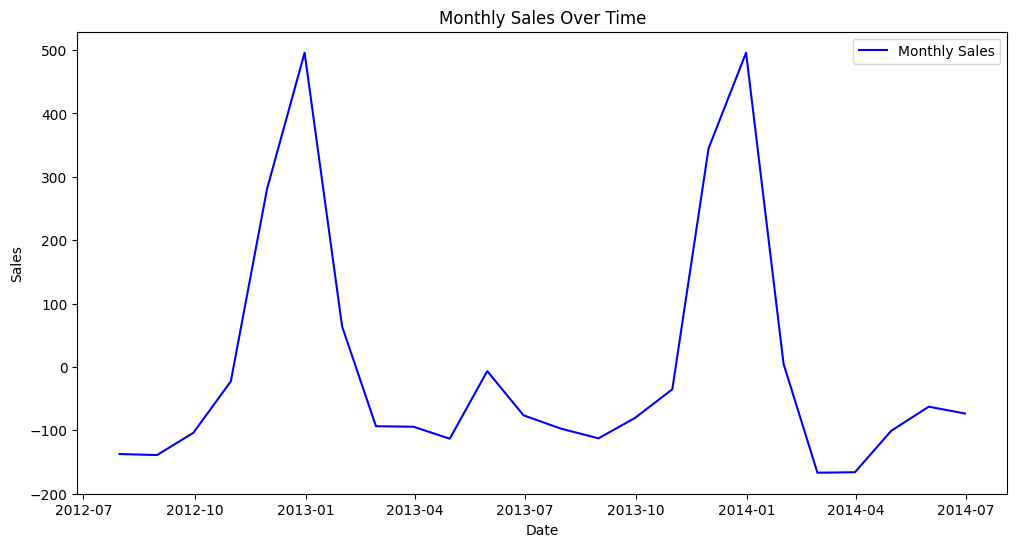

In [45]:
import matplotlib.pyplot as plt

# Plot the sales over time
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Monthly Sales', color='blue')
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [46]:
combined_df.head()

,Sales,Store_Size,Num_Employees,Returns_Pct,Num_Customers,Pct_On_Sale,Marketing,Near_Xmas,Near_BlackFriday,Holiday,...,signup,spot,spring,store,summer,swim,tv,verterns,walk,word
Date,,,,,,,,,,,,,,,,,,,,,
2012-07-01,-0.07,1.66,0.35,0.55,0.25,-0.47,July In Store Credit Card Signup Discount; In ...,0,0,0,...,0.073061,0.0,0.0,0.146122,0.0,0.0,0.0,0.0,0.0,0.3998
2012-07-02,0.00,1.66,-0.74,-0.78,0.10,-0.81,July In Store Credit Card Signup Discount; In ...,0,0,0,...,0.073061,0.0,0.0,0.146122,0.0,0.0,0.0,0.0,0.0,0.3998
2012-07-03,-0.15,1.66,-0.48,-0.99,0.38,-0.73,July In Store Credit Card Signup Discount; In ...,0,0,0,...,0.073061,0.0,0.0,0.146122,0.0,0.0,0.0,0.0,0.0,0.3998
2012-07-04,-0.01,1.66,-0.12,0.12,0.35,-0.44,July In Store Credit Card Signup Discount; In ...,0,0,1,...,0.073061,0.0,0.0,0.146122,0.0,0.0,0.0,0.0,0.0,0.3998
2012-07-05,-0.09,1.66,0.14,-0.56,0.12,-0.51,July In Store Credit Card Signup Discount; ID5...,0,0,0,...,0.244767,0.0,0.0,0.244767,0.0,0.0,0.0,0.0,0.0,0.0000


In [47]:
combined_df.columns

Index(['Sales', 'Store_Size', 'Num_Employees', 'Returns_Pct', 'Num_Customers',
       'Pct_On_Sale', 'Marketing', 'Near_Xmas', 'Near_BlackFriday', 'Holiday',
       'DestinationEvent', 'Marketing_Cleaned', '10', 'accessory', 'ad',
       'april', 'august', 'back', 'billboard', 'black', 'blast', 'blitz',
       'campaign', 'card', 'christmas', 'clearance', 'columbus', 'commercial',
       'credit', 'day', 'dec', 'discount', 'door', 'email', 'end', 'event',
       'fall', 'feb', 'friday', 'gear', 'half', 'halloween', 'holiday',
       'independence', 'july', 'labor', 'last', 'madness', 'mailer', 'march',
       'may', 'memorial', 'minute', 'mlk', 'october', 'president', 'product',
       'promo', 'promotion', 'radio', 'ready', 'roll', 'sale', 'school',
       'september', 'signup', 'spot', 'spring', 'store', 'summer', 'swim',
       'tv', 'verterns', 'walk', 'word'],
      dtype='object')

In [49]:
combined_df.christmas.describe()

count    7090.000000
mean        0.050591
std         0.155790
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.668986
Name: christmas, dtype: float64

In [78]:
features = ['Store_Size', 'Num_Employees', 'Num_Customers', 'Pct_On_Sale', 
            'Near_Xmas', 'Near_BlackFriday', 'Holiday', 
            'DestinationEvent']

combined_df_model = combined_df[['Sales'] + features].copy()

In [79]:
# Check for NaNs in combined_df_model
print(combined_df_model[features].isna().sum())


Store_Size          0
Num_Employees       0
Num_Customers       0
Pct_On_Sale         0
Near_Xmas           0
Near_BlackFriday    0
Holiday             0
DestinationEvent    0
dtype: int64


In [80]:
combined_df_model

,Sales,Store_Size,Num_Employees,Num_Customers,Pct_On_Sale,Near_Xmas,Near_BlackFriday,Holiday,DestinationEvent
Date,,,,,,,,,
2012-07-01,-0.07,1.66,0.35,0.25,-0.47,0,0,0,0
2012-07-02,0.00,1.66,-0.74,0.10,-0.81,0,0,0,0
2012-07-03,-0.15,1.66,-0.48,0.38,-0.73,0,0,0,0
2012-07-04,-0.01,1.66,-0.12,0.35,-0.44,0,0,1,0
2012-07-05,-0.09,1.66,0.14,0.12,-0.51,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2014-06-10,-0.69,0.05,-0.85,-0.51,0.54,0,0,0,0
2014-06-11,-0.43,0.05,-0.59,-0.45,0.13,0,0,0,0
2014-06-12,-0.59,0.05,0.14,-0.51,0.17,0,0,0,0


In [81]:
combined_df_model['ds'] = combined_df.index  # Assuming date is in the index
combined_df_model['y'] = combined_df_model['Sales']
combined_df_model = combined_df_model.drop(['Sales'], axis=1)

In [82]:
combined_df_model.head(3)

,Store_Size,Num_Employees,Num_Customers,Pct_On_Sale,Near_Xmas,Near_BlackFriday,Holiday,DestinationEvent,ds,y
Date,,,,,,,,,,
2012-07-01,1.66,0.35,0.25,-0.47,0,0,0,0,2012-07-01,-0.07
2012-07-02,1.66,-0.74,0.10,-0.81,0,0,0,0,2012-07-02,0.00
2012-07-03,1.66,-0.48,0.38,-0.73,0,0,0,0,2012-07-03,-0.15


In [83]:
nan_rows = combined_df_model[combined_df_model['Store_Size'].isna()]

In [84]:
train_size = int(len(combined_df_model) * 0.8)
train_combined_df = combined_df_model[:train_size]
test_combined_df = combined_df_model[train_size:]

In [85]:
model = Prophet()
for feature in features:
    model.add_regressor(feature)

model.fit(train_combined_df)

17:46:43 - cmdstanpy - INFO - Chain [1] start processing
17:46:46 - cmdstanpy - INFO - Chain [1] done processing


In [89]:
future = model.make_future_dataframe(periods=len(test_combined_df), freq='D')  # Adjust `periods` based on your frequency

In [90]:
future

,ds
0,2012-07-01
1,2012-07-02
2,2012-07-03
3,2012-07-04
4,2012-07-05
...,...
2122,2018-04-28
2123,2018-04-29
2124,2018-04-30
2125,2018-05-01


In [91]:
future = future.merge(combined_df_model[features], how='left', left_on='ds', right_index=True)

In [92]:
future.shape

(8508, 9)

In [93]:
print(future.isna().sum())

ds                     0
Store_Size          1418
Num_Employees       1418
Num_Customers       1418
Pct_On_Sale         1418
Near_Xmas           1418
Near_BlackFriday    1418
Holiday             1418
DestinationEvent    1418
dtype: int64


In [98]:
future.fillna(method='ffill', inplace=True)
future.fillna(method='bfill', inplace=True) 

C:\Users\r.martinez.alonso\AppData\Local\Temp\ipykernel_17072\3070574776.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future.fillna(method='ffill', inplace=True)
C:\Users\r.martinez.alonso\AppData\Local\Temp\ipykernel_17072\3070574776.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future.fillna(method='bfill', inplace=True)


In [99]:
future.isna().sum()

ds                  0
Store_Size          0
Num_Employees       0
Num_Customers       0
Pct_On_Sale         0
Near_Xmas           0
Near_BlackFriday    0
Holiday             0
DestinationEvent    0
dtype: int64

In [100]:
forecast = model.predict(future)

c:\Users\r.martinez.alonso\OneDrive - Accenture\Python\time-series\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 1.5530693846718393


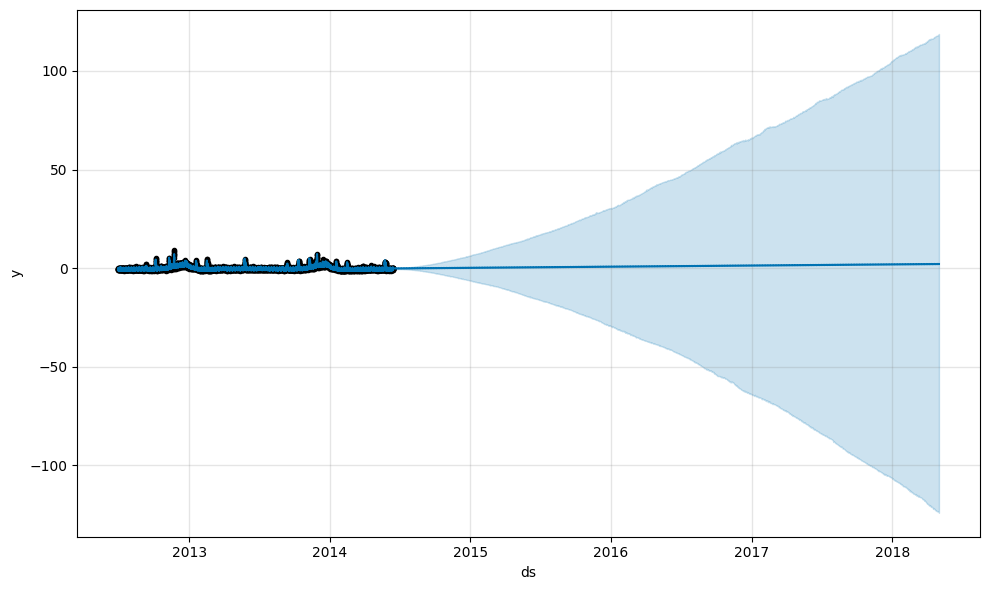

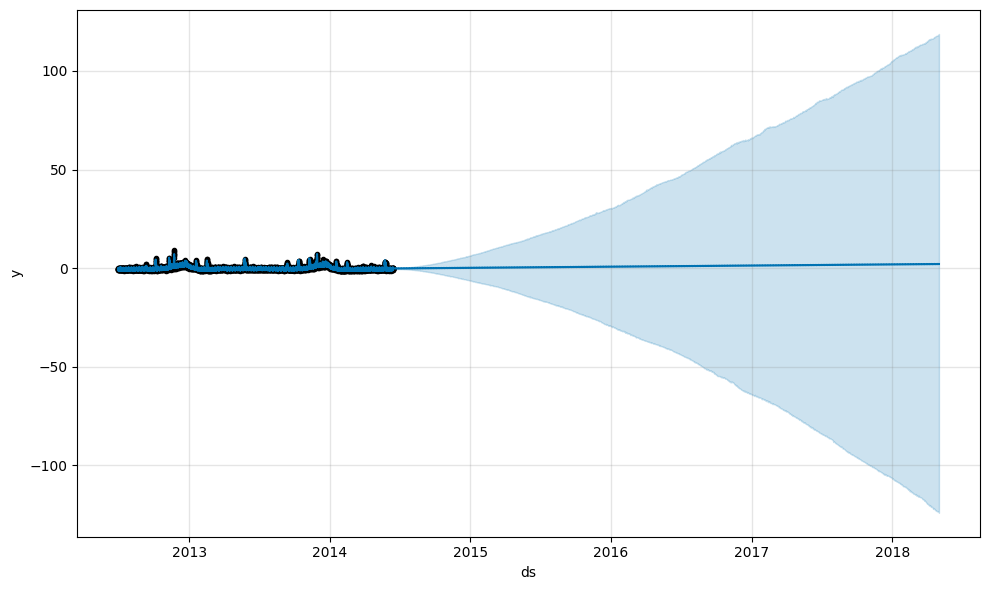

In [102]:
# Step 6: Evaluate the model
from sklearn.metrics import mean_squared_error

y_true = test_combined_df['y']
y_pred = forecast['yhat'][-len(test_combined_df):]  # Predictions for the test period

rmse = mean_squared_error(y_true, y_pred, squared=False)
print(f'RMSE: {rmse}')

# Plot the forecast
model.plot(forecast)


c:\Users\r.martinez.alonso\OneDrive - Accenture\Python\time-series\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 1.5530693846718393
MAE: 1.3708860370596974
R-squared: -1.9448970517658228
Explained Variance Score: -0.32098041102044905


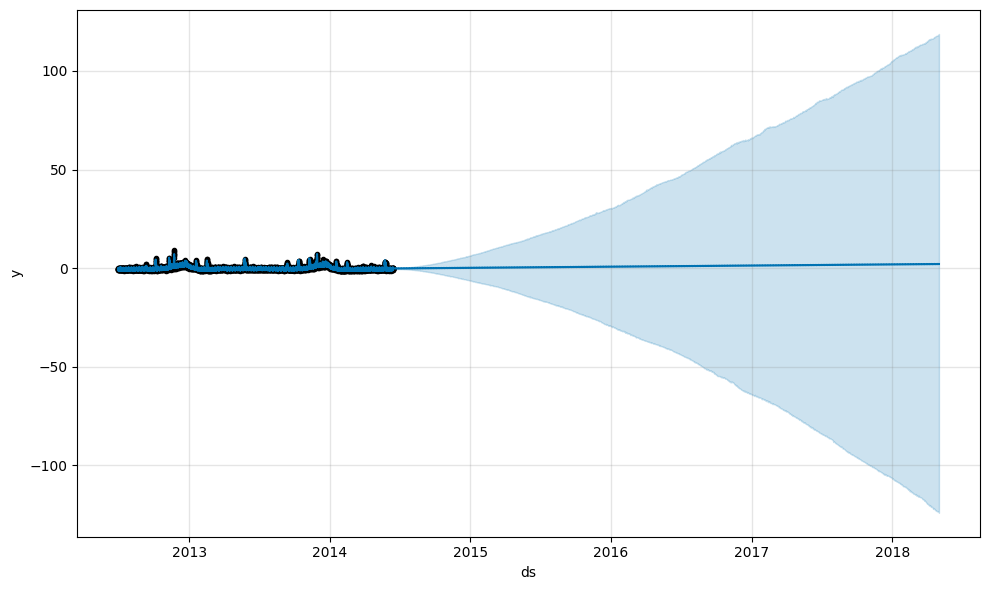

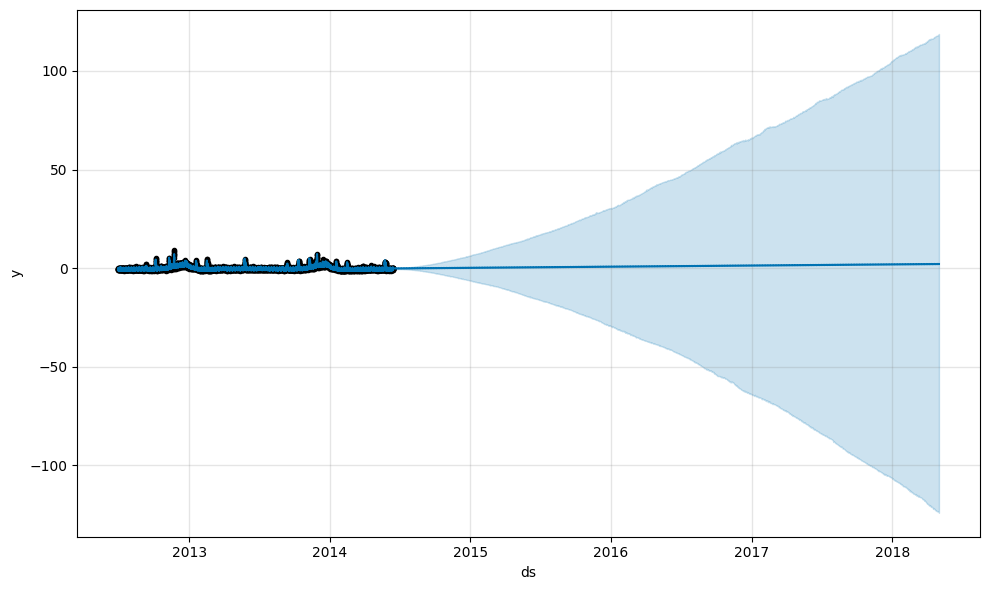

In [106]:
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score, 
    explained_variance_score,
    mean_squared_log_error
)

# Assuming y_true and y_pred are already defined as above

# Calculate RMSE
rmse = mean_squared_error(y_true, y_pred, squared=False)
print(f'RMSE: {rmse}')

# Calculate MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

# Calculate MAPE
# mape = mean_absolute_percentage_error(y_true, y_pred)
# print(f'MAPE: {mape}%')

# Calculate R-squared
r2 = r2_score(y_true, y_pred)
print(f'R-squared: {r2}')

# Calculate Explained Variance Score
explained_variance = explained_variance_score(y_true, y_pred)
print(f'Explained Variance Score: {explained_variance}')

# Calculate MSLE
# msle = mean_squared_log_error(y_true, y_pred)
# print(f'Mean Squared Logarithmic Error: {msle}')

# Plot the forecast
model.plot(forecast)


In [104]:
import sklearn
print(sklearn.__version__)


1.5.2


In [ ]:
df_copia=df.copy(deep=True)

In [ ]:
df_copia.Store.value_counts()

,count
Store,
Louisville,714
Philadelphia,714
Detroit,714
Savannah,714
Portland,714
Columbus,714
Richmond,714
Lancaster,714
Baltimore,714


In [ ]:
# Encode categorical variables
label_encoders = {}
for col in ['Store', 'Holiday', 'DestinationEvent']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store the encoders for future use


In [ ]:
df_copia.head(3)

,Store,Sales,Store_Size,Num_Employees,Returns_Pct,Num_Customers,Pct_On_Sale,Marketing,Near_Xmas,Near_BlackFriday,Holiday,DestinationEvent,Year,Month,DayOfWeek,Day
0,Louisville,76819.40,20100,42,1.03,327,9.96,July In Store Credit Card Signup Discount; In ...,0,0,No,No,2012,7,6,1
1,Louisville,78963.86,20100,21,0.41,293,8.65,July In Store Credit Card Signup Discount; In ...,0,0,No,No,2012,7,0,2
2,Louisville,74824.71,20100,26,0.31,356,8.96,July In Store Credit Card Signup Discount; In ...,0,0,No,No,2012,7,1,3


In [ ]:
binary_cols = ['Near_Xmas', 'Near_BlackFriday', 'Holiday', 'DestinationEvent']
df_copia[binary_cols] = df_copia[binary_cols].apply(lambda x: np.where(x == 'Yes', 1, 0))

In [ ]:
df_copia.head(2)

,Store,Sales,Store_Size,Num_Employees,Returns_Pct,Num_Customers,Pct_On_Sale,Marketing,Near_Xmas,Near_BlackFriday,Holiday,DestinationEvent,Year,Month,DayOfWeek,Day
0,Louisville,76819.40,20100,42,1.03,327,9.96,July In Store Credit Card Signup Discount; In ...,0,0,0,0,2012,7,6,1
1,Louisville,78963.86,20100,21,0.41,293,8.65,July In Store Credit Card Signup Discount; In ...,0,0,0,0,2012,7,0,2


In [ ]:
print(df_copia.isnull().sum())

Store               0
Sales               0
Store_Size          0
Num_Employees       0
Returns_Pct         0
Num_Customers       0
Pct_On_Sale         0
Marketing           0
Near_Xmas           0
Near_BlackFriday    0
Holiday             0
DestinationEvent    0
Year                0
Month               0
DayOfWeek           0
Day                 0
dtype: int64


In [ ]:
df_copia.Marketing.value_counts()

,count
Marketing,
None ID1.2,20
July In Store Credit Card Signup Discount; In store 10% off accessories; Ad Words Independence Day Sale ID6.1339,10
Halloween In Store Credit Card Signup Discount; ID220.8835,10
Halloween In Store Credit Card Signup Discount; ID25.8171,10
Halloween In Store Credit Card Signup Discount; ID43.2051,10
...,...
Feb. In Store Credit Card Signup Discount; ID9.2267,10
Feb. In Store Credit Card Signup Discount; ID43.1332,10
Feb. In Store Credit Card Signup Discount; ID36.1579,10


In [ ]:
df.shape

(7140, 16)

In [ ]:
df.head(3)

,Store,Sales,Store_Size,Num_Employees,Returns_Pct,Num_Customers,Pct_On_Sale,Marketing,Near_Xmas,Near_BlackFriday,Holiday,DestinationEvent,Year,Month,DayOfWeek,Day
0,4,76819.40,20100,42,1.03,327,9.96,July In Store Credit Card Signup Discount; In ...,0,0,0,0,2012,7,6,1
1,4,78963.86,20100,21,0.41,293,8.65,July In Store Credit Card Signup Discount; In ...,0,0,0,0,2012,7,0,2
2,4,74824.71,20100,26,0.31,356,8.96,July In Store Credit Card Signup Discount; In ...,0,0,0,0,2012,7,1,3


Black Friday no relation

In [ ]:
df_bf=df_copia[df_copia['Marketing'].str.contains('Black Friday')]

In [ ]:
df_bf.shape

(340, 16)

In [ ]:
df_bf.Near_BlackFriday.value_counts()

,count
Near_BlackFriday,
0,340


In [ ]:
df_copia.shape

(7140, 16)

In [ ]:
df_copia.head()

,Store,Sales,Store_Size,Num_Employees,Returns_Pct,Num_Customers,Pct_On_Sale,Marketing,Near_Xmas,Near_BlackFriday,Holiday,DestinationEvent,Year,Month,DayOfWeek,Day
0,Louisville,76819.40,20100,42,1.03,327,9.96,July In Store Credit Card Signup Discount; In ...,0,0,0,0,2012,7,6,1
1,Louisville,78963.86,20100,21,0.41,293,8.65,July In Store Credit Card Signup Discount; In ...,0,0,0,0,2012,7,0,2
2,Louisville,74824.71,20100,26,0.31,356,8.96,July In Store Credit Card Signup Discount; In ...,0,0,0,0,2012,7,1,3
3,Louisville,78523.92,20100,33,0.83,350,10.08,July In Store Credit Card Signup Discount; In ...,0,0,1,0,2012,7,2,4
4,Louisville,76445.90,20100,38,0.51,299,9.80,July In Store Credit Card Signup Discount; ID5...,0,0,0,0,2012,7,3,5


In [ ]:
df_copia.Near_BlackFriday.value_counts()

,count
Near_BlackFriday,
0,7140


In [ ]:
df_modelo=df_copia.copy(deep=True)

Elegir variables relevantes

NLP Project

In [ ]:
df_nlp=df.copy(deep=True)

In [ ]:
df_nlp=df_nlp[['Marketing', 'Sales']]

In [ ]:
a=df_nlp['Marketing'].iloc()

In [ ]:
import re
from collections import defaultdict

lines = df_nlp.strip().split('\n')

# Initialize a defaultdict to hold cleaned text
cleaned_text = defaultdict(int)

for line in lines:
    # Remove IDs (anything that starts with ID and followed by numbers and periods)
    cleaned_line = re.sub(r'\s*ID[\d.]+', '', line)

    # Split by semicolon to get individual promotions
    promotions = [promo.strip() for promo in cleaned_line.split(';') if promo.strip()]

    for promo in promotions:
        cleaned_text[promo] += 1

# Combine and format the cleaned results
result = []
for promo, count in cleaned_text.items():
    if count > 1:
        result.append(f"{promo} (x{count})")  # Add a count if there are duplicates
    else:
        result.append(promo)

# Join the final cleaned and combined text
final_output = ' | '.join(result)
print(final_output)
